<a href="https://colab.research.google.com/github/Quark-hadron/game_of_thrones_prediction/blob/main/game_of_thrones_prediction_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Описание данных:

* **name**: Имя персонажа

* **Title**: Социальный статус или знатность

* **House**: Дом, к которому принадлежит персонаж

* **Culture**: Социальная группа, к которой принадлежит персонаж

* **book1/2/3/4/5**: Появление персонажа в книге

* **Is noble**: Знатность персонажа, основанное на титуле

* **Age**: Отсчет времени: 305 AC

* **male**: Мужчина или женщина

* **dateOfBirth**: дата рождения

* **Spouse**: Имя супруги\а персонажа

* **Father**: Имя отца персонажа

* **Mother**: Имя матери персонажа

* **Heir**: Имя наследника персонажа

* **Is married**: Represents whether the character is married

* **Is spouse alive**: Represents whether character's spouse is alive

* **Is mother alive:** Жива ли мать персонажа

* **Is heir alive:** Жив ли наследник персонажа

* **Is father alive:** Указывает, жив ли отец персонажа

* **Number dead relations:** Количество умерших персонажей, с которыми персонаж связан

* **Popularity score:** Количество внутренних входящих и исходящих ссылок на страницу персонажей в вики http://awoiaf.westeros.org

Целевая переменная:
* **isAlive**: жив ли персонаж в книге

Оценивание:

Баллы считаются следующим образом:

1) $1.00 \geqslant score \geqslant 0.80$ --- 5 баллов

2) $0.80 > score \geqslant 0.77$ --- 4 балла

3) $0.77 > score \geqslant 0.70$ --- 3 балла

4) $0.70 > score \geqslant 0.65$ --- 2 балла

5) $0.65 > score \geqslant 0.50$ --- 1 балл

6) $score < 0.50$ --- 0 баллов

## Часть 1. Анализ и предобработка данных

Здесь вам необходимо сделать все шаги, которые обсуждались в первой части семинара.
* Предобработка данных
  * Обработка пропущенных данных
  * Создание новых признаков
  * Удаление ненужных столбцов
* Анализ данных
  * Анализ целевой переменной
  * Анализ признаков
  * Анализ влияния признаков на целевую переменную
* Подготовка данных для обучения модели

Загружаем датасет

In [1]:
!gdown 1h99toeF7lZ2I3iJwehgKO-QQmDaOe_O3 # test dataset
!gdown 1XL0VTygpZj-ZAuTNRBgApZTPQyNDnT-v # train dataset
!gdown 1M14conWjAW2QLoyCXbHEAy8bql2f99eF

Downloading...
From: https://drive.google.com/uc?id=1h99toeF7lZ2I3iJwehgKO-QQmDaOe_O3
To: /content/game_of_thrones_test.csv
100% 37.3k/37.3k [00:00<00:00, 56.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XL0VTygpZj-ZAuTNRBgApZTPQyNDnT-v
To: /content/game_of_thrones_train.csv
100% 138k/138k [00:00<00:00, 15.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1M14conWjAW2QLoyCXbHEAy8bql2f99eF
To: /content/submission.csv
100% 2.74k/2.74k [00:00<00:00, 5.29MB/s]


In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from scipy.stats import shapiro

In [3]:
df = pd.read_csv('/content/game_of_thrones_train.csv',index_col='S.No')
data = pd.read_csv('/content/game_of_thrones_test.csv',index_col='S.No')

In [4]:
data.head()

,name,title,male,culture,dateOfBirth,mother,father,heir,house,spouse,...,book5,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity
S.No,,,,,,,,,,,,,,,,,,,,,
1558,Melissa Blackwood,NaN,0,NaN,156.0,NaN,NaN,NaN,House Blackwood,NaN,...,1,NaN,NaN,NaN,NaN,0,0,100.0,0,0.050167
1559,Melisandre,NaN,0,Asshai,NaN,NaN,NaN,NaN,R'hllor,NaN,...,1,NaN,NaN,NaN,NaN,0,0,NaN,0,0.745819
1560,Merrit,NaN,0,NaN,NaN,NaN,NaN,NaN,Brotherhood without banners,NaN,...,0,NaN,NaN,NaN,NaN,0,0,NaN,0,0.010033
1561,Meryn Trant,Ser,1,NaN,NaN,NaN,NaN,NaN,House Trant,NaN,...,1,NaN,NaN,NaN,NaN,0,1,NaN,0,0.220736
1562,Merrett Frey,NaN,1,Riverlands,262.0,NaN,NaN,NaN,House Frey,Mariya Darry,...,1,NaN,NaN,NaN,1.0,1,0,38.0,0,0.434783


In [5]:
df.head()

,name,title,male,culture,dateOfBirth,mother,father,heir,house,spouse,...,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive
S.No,,,,,,,,,,,,,,,,,,,,,
1,Viserys II Targaryen,NaN,1,NaN,NaN,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,NaN,NaN,...,1.0,0.0,0.0,NaN,0,0,NaN,11,0.605351,0
2,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,NaN,NaN,NaN,House Frey,Perra Royce,...,NaN,NaN,NaN,1.0,1,1,97.0,1,0.896321,1
3,Addison Hill,Ser,1,NaN,NaN,NaN,NaN,NaN,House Swyft,NaN,...,NaN,NaN,NaN,NaN,0,1,NaN,0,0.267559,1
4,Aemma Arryn,Queen,0,NaN,82.0,NaN,NaN,NaN,House Arryn,Viserys I Targaryen,...,NaN,NaN,NaN,0.0,1,1,23.0,0,0.183946,0
5,Sylva Santagar,Greenstone,0,Dornish,276.0,NaN,NaN,NaN,House Santagar,Eldon Estermont,...,NaN,NaN,NaN,1.0,1,1,29.0,0,0.043478,1


In [6]:
df['title'] = df['title'].fillna(df['title'].value_counts().idxmax())
df['age'] = df['age'].fillna(df['age'].value_counts().idxmax())
data['title'] = data['title'].fillna(data['title'].value_counts().idxmax())
data['age'] = data['age'].fillna(data['age'].value_counts().idxmax())

In [7]:
df.shape

(1557, 25)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1557 entries, 1 to 1557
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1557 non-null   object 
 1   title             1557 non-null   object 
 2   male              1557 non-null   int64  
 3   culture           488 non-null    object 
 4   dateOfBirth       279 non-null    float64
 5   mother            18 non-null     object 
 6   father            22 non-null     object 
 7   heir              21 non-null     object 
 8   house             1176 non-null   object 
 9   spouse            200 non-null    object 
 10  book1             1557 non-null   int64  
 11  book2             1557 non-null   int64  
 12  book3             1557 non-null   int64  
 13  book4             1557 non-null   int64  
 14  book5             1557 non-null   int64  
 15  isAliveMother     18 non-null     float64
 16  isAliveFather     22 non-null     float64
 17  

In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
df.isna().sum()

,0
name,0
title,0
male,0
culture,1069
dateOfBirth,1278
mother,1539
father,1535
heir,1536
house,381
spouse,1357


In [11]:
df['name'].unique().shape

(1557,)

In [12]:
df.drop('name', axis=1, inplace=True)
data.drop('name', axis=1, inplace=True)

In [13]:
df['mother'].value_counts(dropna=False).iloc[0]

np.int64(1539)

In [14]:
df['father'].value_counts(dropna=False).iloc[0]

np.int64(1535)

In [15]:
df['heir'].value_counts(dropna=False).iloc[0]

np.int64(1536)

In [16]:
df['isAliveMother'].value_counts(dropna=False).iloc[0]

np.int64(1539)

In [17]:
df['isAliveFather'].value_counts(dropna=False).iloc[0]

np.int64(1535)

In [18]:
df['isAliveHeir'].value_counts(dropna=False).iloc[0]

np.int64(1536)

In [19]:
df['isAliveSpouse'].value_counts(dropna=False).iloc[0]

np.int64(1357)

In [20]:
df['spouse'].value_counts(dropna=False).iloc[0]

np.int64(1357)

In [21]:
df['age'].value_counts(dropna=False).iloc[0]

np.int64(1298)

In [22]:
df['dateOfBirth'].value_counts(dropna=False).iloc[0]

np.int64(1278)

In [23]:
df['culture'].value_counts(dropna=False)

,count
culture,
NaN,1069
Northmen,94
Ironborn,91
Free Folk,45
Braavosi,39
Valyrian,28
Ghiscari,17
Dornish,17
Dothraki,17


In [24]:
df['cult'] = df['culture'].fillna(df['culture'].value_counts().idxmax())
data['cult'] = data['culture'].fillna(data['culture'].value_counts().idxmax())

In [25]:
df['cult'].value_counts()

,count
cult,
Northmen,1163
Ironborn,91
Free Folk,45
Braavosi,39
Valyrian,28
Ghiscari,17
Dornish,17
Dothraki,17
Reach,13


In [26]:
cult = {
    'Summer Islands': ['summer islands', 'summer islander', 'summer isles'],
    'Ghiscari': ['ghiscari', 'ghiscaricari',  'ghis'],
    'Asshai': ["asshai'i", 'asshai'],
    'Lysene': ['lysene', 'lyseni'],
    'Andal': ['andal', 'andals'],
    'Braavosi': ['braavosi', 'braavos'],
    'Dornish': ['dornishmen', 'dorne', 'dornish'],
    'Myrish': ['myr', 'myrish', 'myrmen'],
    'Westermen': ['westermen', 'westerman', 'westerlands'],
    'Westerosi': ['westeros', 'westerosi'],
    'Stormlander': ['stormlands', 'stormlander'],
    'Norvoshi': ['norvos', 'norvoshi'],
    'Northmen': ['the north', 'northmen'],
    'Free Folk': ['wildling', 'first men', 'free folk'],
    'Qartheen': ['qartheen', 'qarth'],
    'Reach': ['the reach', 'reach', 'reachmen'],
}

In [27]:
def culter(value):
    for k, v in cult.items():
      for i in v:
        if value == i:
          value = k
          return value

In [28]:
df['cult'] = df['cult'].apply(lambda x: culter(x))
data['cult'] = data['cult'].apply(lambda x: culter(x))

In [29]:
df['title'].value_counts(dropna=False).iloc[0]

np.int64(1146)

In [30]:
df.drop(['mother','father','heir','isAliveMother','isAliveFather','isAliveHeir','isAliveSpouse','spouse','dateOfBirth','culture'], axis=1, inplace=True)#,'age','title','cult'

In [31]:
data.drop(['mother','father','heir','isAliveMother','isAliveFather','isAliveHeir','isAliveSpouse','spouse','dateOfBirth','culture'], axis=1, inplace=True)

In [32]:
df.rename(columns={'male':'sex'},inplace=True)
data.rename(columns={'male':'sex'},inplace=True)

In [33]:
df['house'] = df['house'].fillna(df['house'].value_counts().idxmax())
data['house'] = data['house'].fillna(data['house'].value_counts().idxmax())

In [34]:
df.isna().sum()

,0
title,0
sex,0
house,0
book1,0
book2,0
book3,0
book4,0
book5,0
isMarried,0
isNoble,0


In [35]:
le = LabelEncoder()

In [36]:
df['house'] = le.fit_transform(df['house'])
df['cult'] = le.fit_transform(df['cult'])
df['title'] = le.fit_transform(df['title'])
df['age'] = le.fit_transform(df['age'])

In [37]:
data['house'] = le.fit_transform(data['house'])
data['cult'] = le.fit_transform(data['cult'])
data['title'] = le.fit_transform(data['title'])
data['age'] = le.fit_transform(data['age'])

In [38]:
le.classes_

array([-2.98001e+05, -2.77980e+05,  1.00000e+00,  3.00000e+00,
        5.00000e+00,  6.00000e+00,  1.00000e+01,  1.20000e+01,
        1.30000e+01,  1.40000e+01,  1.50000e+01,  1.60000e+01,
        1.70000e+01,  1.80000e+01,  1.90000e+01,  2.00000e+01,
        2.10000e+01,  2.20000e+01,  2.30000e+01,  2.40000e+01,
        2.50000e+01,  2.60000e+01,  2.70000e+01,  2.80000e+01,
        2.90000e+01,  3.00000e+01,  3.10000e+01,  3.20000e+01,
        3.40000e+01,  3.50000e+01,  3.60000e+01,  3.70000e+01,
        3.80000e+01,  3.90000e+01,  4.10000e+01,  4.20000e+01,
        4.30000e+01,  4.50000e+01,  4.70000e+01,  4.80000e+01,
        4.90000e+01,  5.20000e+01,  5.30000e+01,  5.40000e+01,
        5.50000e+01,  5.60000e+01,  5.80000e+01,  6.00000e+01,
        6.20000e+01,  6.30000e+01,  6.50000e+01,  6.60000e+01,
        6.80000e+01,  6.90000e+01,  7.00000e+01,  7.20000e+01,
        7.60000e+01,  7.70000e+01,  7.90000e+01,  8.10000e+01,
        8.40000e+01,  8.80000e+01,  9.30000e+01,  1.000

In [39]:
df['isPopularity'] = df['popularity'].apply(lambda x: x >=0.5, 1, 0 ).astype('int8')
df['isDeadRelations'] = df['numDeadRelations'].apply(lambda x: x >0, 1, 0 ).astype('int8')
data['isPopularity'] = data['popularity'].apply(lambda x: x >=0.5, 1, 0 ).astype('int8')
data['isDeadRelations'] = data['numDeadRelations'].apply(lambda x: x >0, 1, 0 ).astype('int8')

<ipython-input-39-ee932708716c>:1: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df['isPopularity'] = df['popularity'].apply(lambda x: x >=0.5, 1, 0 ).astype('int8')
<ipython-input-39-ee932708716c>:2: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df['isDeadRelations'] = df['numDeadRelations'].apply(lambda x: x >0, 1, 0 ).astype('int8')
<ipython-input-39-ee932708716c>:3: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  data['isPopularity'] = data['popularity'].apply(lambda x: x >=0.5, 1, 0 ).astype('int8')
<ipython-input-39-ee932708716c>:4: FutureWarning: the convert_dtype parameter is deprecate

In [40]:
df.head()

,title,sex,house,book1,book2,book3,book4,book5,isMarried,isNoble,age,numDeadRelations,popularity,isAlive,cult,isPopularity,isDeadRelations
S.No,,,,,,,,,,,,,,,,,
1,163,1,106,0,0,0,0,0,0,0,71,11,0.605351,0,3,1,1
2,115,1,106,1,1,1,1,1,1,1,70,1,0.896321,1,3,1,1
3,163,1,244,0,0,0,1,0,0,1,71,0,0.267559,1,3,0,0
4,145,0,21,0,0,0,0,0,1,1,20,0,0.183946,0,3,0,0
5,53,0,219,0,0,0,1,0,1,1,26,0,0.043478,1,3,0,0


<Axes: >

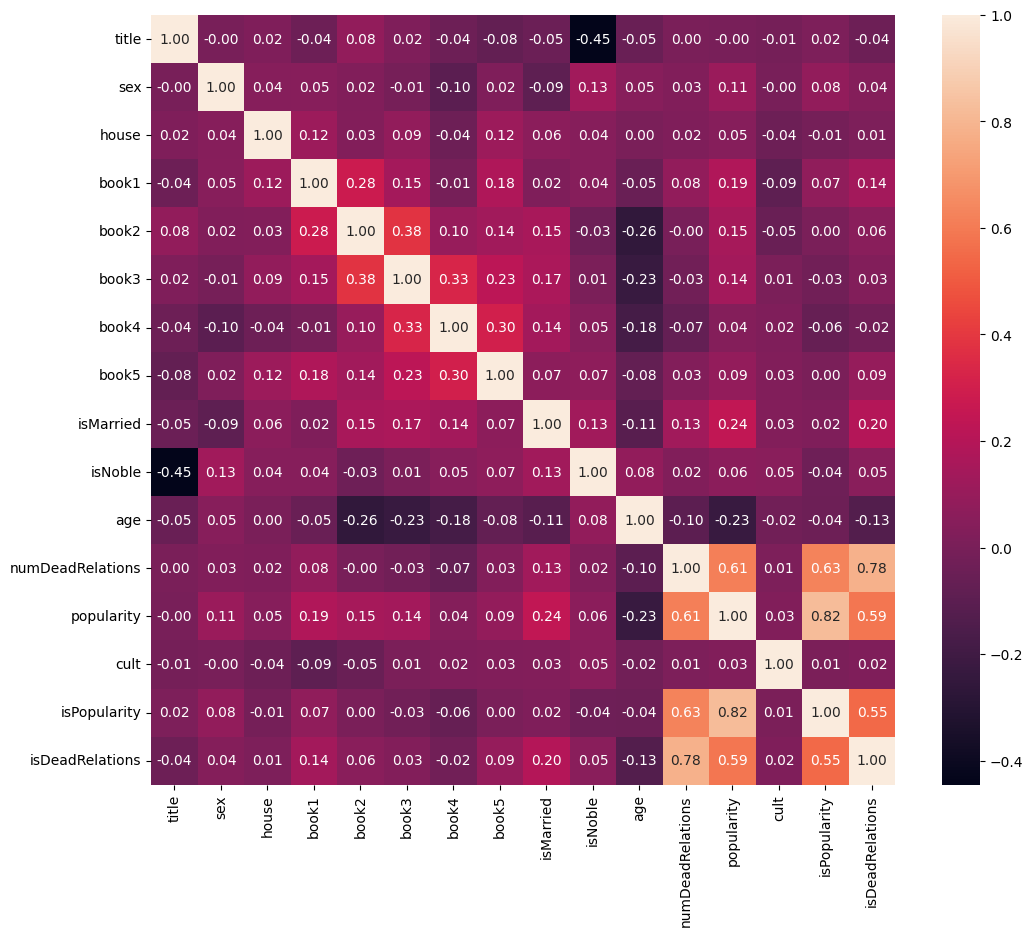

In [41]:
plt.figure(figsize=(12,10))
sns.heatmap(df.drop('isAlive', axis=1).corr(),annot=True, fmt='.2f')

In [42]:
df['isAlive'].value_counts(normalize=True)

,proportion
isAlive,
1,0.77842
0,0.22158


<Axes: xlabel='isAlive', ylabel='count'>

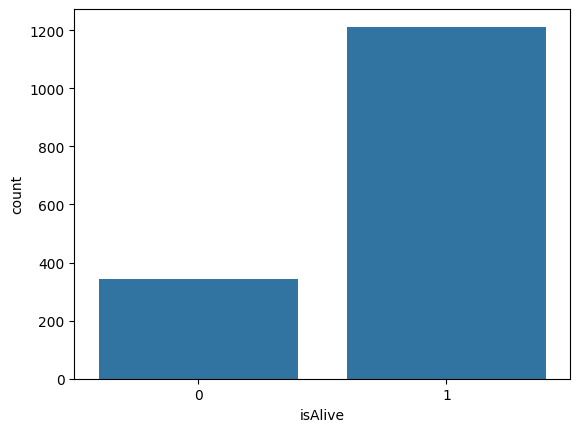

In [43]:
sns.countplot(data=df,x='isAlive')

In [44]:
X = df.drop('isAlive', axis=1)
y = df['isAlive']

In [95]:
stat, p_value = shapiro(y)

In [96]:
p_value

np.float64(3.587015825467958e-54)

In [97]:
if p_value > 0.05:
    print("Данные нормальны (не отвергаем H0)")
else:
    print("Данные не нормальны (отвергаем H0)")


Данные не нормальны (отвергаем H0)


In [45]:
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X,y)

SelectKBest(k='all')

In [46]:
rate = pd.DataFrame(fs.scores_, X.columns, columns=['score'])
rate = rate.sort_values('score', axis=0, ascending=False)

In [47]:
rate

,score
book4,136.438124
numDeadRelations,64.035697
popularity,60.934519
isDeadRelations,50.985201
sex,34.963354
isPopularity,22.212396
book1,19.921336
house,15.580600
isNoble,5.726291
book2,4.891426


In [48]:
cols = rate.index.values[::-1]

In [49]:
features = X[[col for col in cols[: len(cols) // 2]]]

In [50]:
features

,title,book3,book5,age,isMarried,cult,book2,isNoble
S.No,,,,,,,,
1,163,0,0,71,0,3,0,0
2,115,1,1,70,1,3,1,1
3,163,0,0,71,0,3,0,1
4,145,0,0,20,1,3,0,1
5,53,0,0,26,1,3,0,1
...,...,...,...,...,...,...,...,...
1553,1,1,0,71,0,3,0,1
1554,163,0,0,71,0,3,1,0
1555,163,1,1,71,0,3,1,0


In [51]:
smote = SMOTE()

In [52]:
X_smote, y_smote = smote.fit_resample(X.values, y.values)

In [53]:
X_smote.shape

(2424, 16)

In [54]:
y_smote.shape

(2424,)

In [55]:
x_train, x_test, y_train, y_test = train_test_split(X_smote,y_smote, test_size=0.2, random_state=1)

In [56]:
x_train.shape

(1939, 16)

In [57]:
x_test.shape

(485, 16)

In [58]:
np.random.seed(100)
logr = LogisticRegression(n_jobs=-1,max_iter=200,class_weight='balanced')

In [59]:
logr.fit(x_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=200, n_jobs=-1)

In [60]:
y_pred = logr.predict(x_test)

In [61]:
accuracy_score(y_test, y_pred)

0.6721649484536083

In [62]:
model = {
'LogisticRegression':LogisticRegression(n_jobs=-1, max_iter=200),
'DecisionTreeClassifier':DecisionTreeClassifier(),
'RandomForestClassifier':RandomForestClassifier(),
'KNeighborsClassifier':KNeighborsClassifier(),
'XGBClassifier':XGBClassifier(),
'LGBMClassifier':LGBMClassifier(),
'XGBRFClassifier':XGBRFClassifier(),
'DummyClassifier':DummyClassifier(),
'AdaBoostClassifier':AdaBoostClassifier(),
'GaussianProcessClassifier':GaussianProcessClassifier(),
'GaussianNB':GaussianNB(),
'SVC':SVC()

}

best_score = 0

In [63]:

np.random.seed(23)
for name, model in model.items():
   model.fit(x_train,y_train)
   y_pred = model.predict(x_test)
   acc = accuracy_score(y_test,y_pred)
   print(f'{name} --> {acc}')

   if acc > best_score:
       best_score = acc
       best_model_name = name
       best_model = model

print(f'{best_model_name} : {best_score}')

LogisticRegression --> 0.6845360824742268
DecisionTreeClassifier --> 0.8577319587628865
RandomForestClassifier --> 0.8783505154639175
KNeighborsClassifier --> 0.777319587628866
XGBClassifier --> 0.8845360824742268
[LightGBM] [Info] Number of positive: 971, number of negative: 968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1418
[LightGBM] [Info] Number of data points in the train set: 1939, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500774 -> initscore=0.003094
[LightGBM] [Info] Start training from score 0.003094
LGBMClassifier --> 0.8824742268041237


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


XGBRFClassifier --> 0.8103092783505155
DummyClassifier --> 0.49690721649484537
AdaBoostClassifier --> 0.7876288659793814
GaussianProcessClassifier --> 0.797938144329897
GaussianNB --> 0.5814432989690722
SVC --> 0.5381443298969072
XGBClassifier : 0.8845360824742268


In [64]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [65]:
y_pred = best_model.predict(x_test)

In [66]:
accuracy_score(y_test,y_pred)

0.8845360824742268

In [67]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       244
           1       0.88      0.89      0.88       241

    accuracy                           0.88       485
   macro avg       0.88      0.88      0.88       485
weighted avg       0.88      0.88      0.88       485



<Axes: >

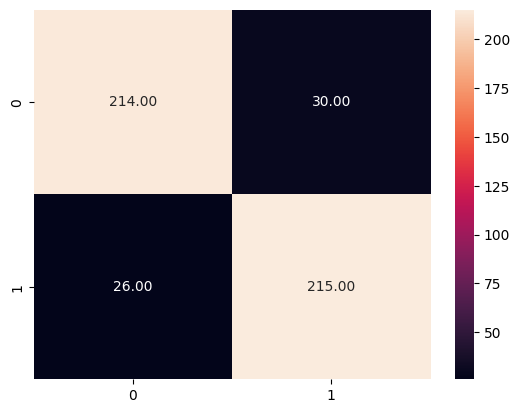

In [68]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True, fmt='.2f')

In [69]:
feature_name = [i for i in X.columns]

In [70]:
feature_name

['title',
 'sex',
 'house',
 'book1',
 'book2',
 'book3',
 'book4',
 'book5',
 'isMarried',
 'isNoble',
 'age',
 'numDeadRelations',
 'popularity',
 'cult',
 'isPopularity',
 'isDeadRelations']

In [71]:
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)

RandomForestClassifier()

In [72]:
importances = rfc.feature_importances_

In [73]:
importances

array([0.04489433, 0.0835877 , 0.1379787 , 0.04112048, 0.04100279,
       0.04224409, 0.18380155, 0.04563432, 0.01928472, 0.0356796 ,
       0.03176025, 0.01501315, 0.25984461, 0.00304902, 0.00186318,
       0.01324149])

In [74]:
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

In [75]:
features_importances = pd.Series(data=importances, index=feature_name)

<Axes: >

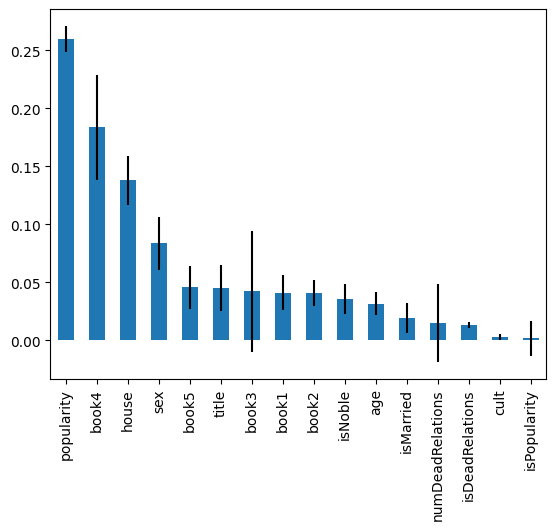

In [76]:
features_importances.sort_values(ascending=False).plot.bar(yerr=std)

In [77]:
y_prob = best_model.predict_proba(x_test)[:,1]

In [78]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
score = roc_auc_score(y_test,y_prob)

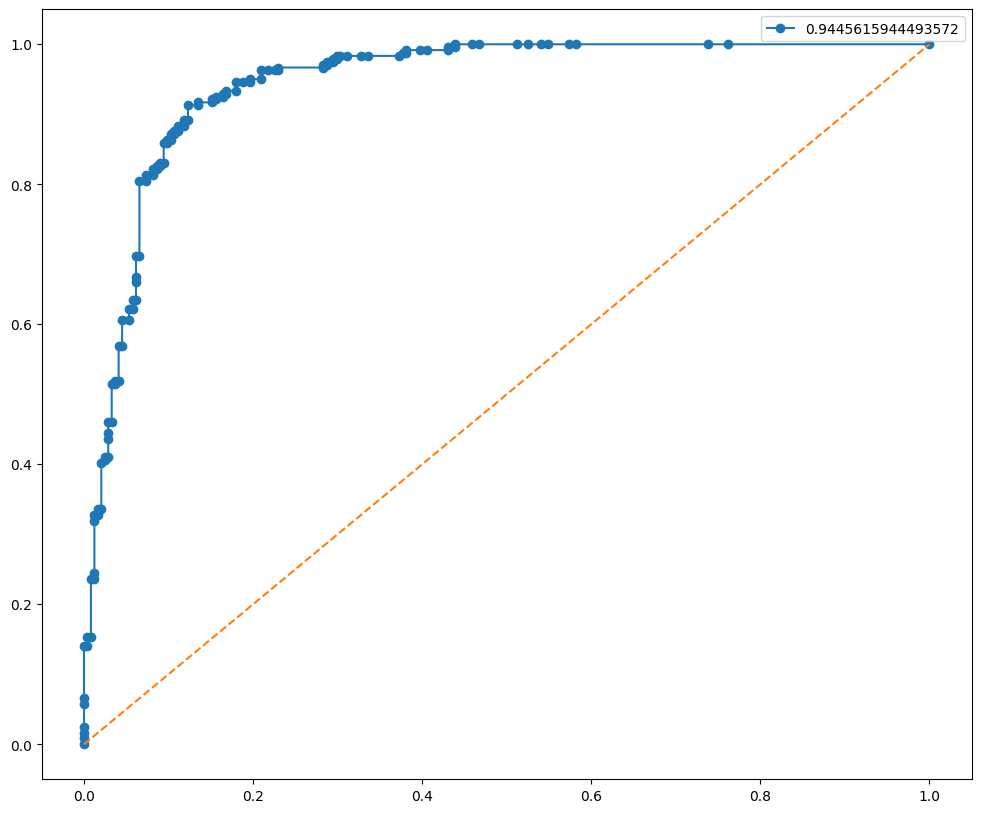

In [79]:
plt.figure(figsize=(12,10))
plt.plot(fpr, tpr, marker='o', label=score)
plt.plot([0,1],[0,1],linestyle='--')
plt.legend()

In [80]:
data.head()

,title,sex,house,book1,book2,book3,book4,book5,isMarried,isNoble,age,numDeadRelations,popularity,cult,isPopularity,isDeadRelations
S.No,,,,,,,,,,,,,,,,
1558,94,0,22,0,0,0,0,1,0,0,63,0,0.050167,0,0,0
1559,94,0,128,0,1,1,1,1,0,0,63,0,0.745819,0,1,0
1560,94,0,6,0,0,1,1,0,0,0,63,0,0.010033,0,0,0
1561,94,1,106,1,1,1,1,1,0,1,63,0,0.220736,0,0,0
1562,94,1,50,1,1,1,1,1,1,0,32,0,0.434783,0,0,0


In [81]:
!gdown 1M14conWjAW2QLoyCXbHEAy8bql2f99eF

Downloading...
From: https://drive.google.com/uc?id=1M14conWjAW2QLoyCXbHEAy8bql2f99eF
To: /content/submission.csv
100% 2.74k/2.74k [00:00<00:00, 12.3MB/s]


In [82]:
submission = pd.read_csv("/content/submission.csv", index_col='S.No')

In [83]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [84]:
y_pred_data = best_model.predict(np.array(data))

In [85]:
submission['isAlive'] = y_pred_data

In [86]:
submission

,isAlive
S.No,
1558,0
1559,1
1560,1
1561,1
1562,0
...,...
1942,0
1943,0
1944,0


In [87]:
submission.to_csv("/content/submission.csv", index=False,sep=';')